In [1]:
%env CUDA_VISIBLE_DEVICES -1

env: CUDA_VISIBLE_DEVICES=-1


# Пример обучения свёрточной сети для задачи сегментации

In [2]:
import tensorflow as tf
import tensorflow.keras as K
import random
from itertools import islice
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

## Работа с данными

### Подгрузка данных датасета

In [3]:
# Подключение Google диска (для Jupyter Collab)
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Функция для получения списков изображений
def get_masks_path(images_folder):
    return [str(x) for x in Path(images_folder).glob('*.jpg')]

In [5]:
# Функция для получения контура пятен на изображении.
def get_border(binary_image, border_width):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (border_width, border_width))
    return cv2.morphologyEx(binary_image, cv2.MORPH_GRADIENT, kernel)
    # расширяем, потом сужаем, разница между ними - граница

# Функция-генератор для чтения масок, применения аугментаций, нормирования, генерации входных данных сети.
def create_data_generator(masks_paths, tgt_size, batch_size, border_size=2, aug_fn=None):
    # Sort data
    masks_paths = masks_paths[:]
    random.shuffle(masks_paths)

    batched_inputs = []
    batched_labels = []

    for mask_path in masks_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # shape [h, w]
        if aug_fn is not None:
            mask = aug_fn(mask)
        
        # Приводим к одному пространственному размеру
        mask = cv2.resize(mask, (tgt_size, tgt_size))
        
        # Для данной задачи features и labels мы можем сгенерировать автоматически (учебный пример)
        labels = mask / 255.  # Нормируем данные от 0 до 1
        input_data = get_border(mask, border_size) / 255.  # После генерации контура мы также производим нормировку

        # Приводим к виду, с которым работает свёрточная сеть (добавляем размерность каналов)
        labels = labels[..., None]  # эквивалентно добавлении оси в конец при помощи expand_dims.
        input_data = input_data[..., None]
        
        # Добавляем данные в батч
        batched_inputs.append(input_data)
        batched_labels.append(labels)
            
        if len(batched_inputs) == batch_size:
            # Возвращаем два массива, представляющие собой батч для входа сети, 
            # и батч с метками (labels / ground truth (GT))
            batched_inputs_array  = np.array(batched_inputs, np.float32)
            batched_labels_aray = np.array(batched_labels, np.float32)
            yield batched_inputs_array, batched_labels_aray
            # Отчищаем данные батча
            batched_inputs = []
            batched_labels = []


def train_generator(masks_paths, tgt_size, batch_size, epochs_num, border_size=2, aug_fn=None):
    for _ in range(epochs_num):
        data_generator = create_data_generator(masks_paths, tgt_size, batch_size, border_size, aug_fn)
        yield from data_generator
        
        #for x in data_generator:
            #yield x

### Аугментация данных

In [6]:
# Функции для аyгментирования данных

def get_random_slice(size, min_size_frac=0.2):
    # Вычисляем случайный одномерный срез
    slice_size = random.randint(int(min_size_frac * size), size)
    
    slice_start = random.randint(0, size - slice_size)
    slice_end = slice_start + slice_size
    
    return slice(slice_start, slice_end)


def img_random_crop(img, min_size_frac=0.2):
    h, w = img.shape[:2]
    width_slice = get_random_slice(w, min_size_frac)
    height_slice = get_random_slice(h, min_size_frac)
    return img[height_slice, width_slice]


def img_random_rotate(img):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    angle = random.randint(-180, 180)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    return cv2.warpAffine(img, rotation_matrix, (h,w))


def augmentation_function(img):
    
    # Случайное отражение
    # (двойное отражение покрывается возможностью произвести поворот на 180 градусов)
    if random.random() < 0.5:
        img = cv2.flip(img, 1)

    # Случайное отражение
    if random.random() < 0.5:
        img = img_random_rotate(img)

    return img

### Пример данных

In [7]:
imgs_paths = get_masks_path('nails_segmentation\labels')

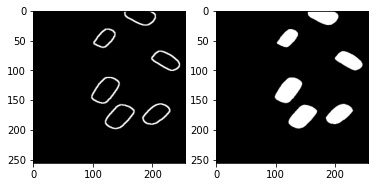

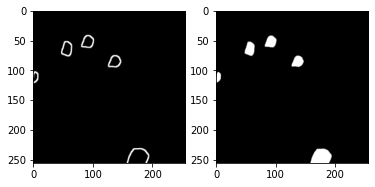

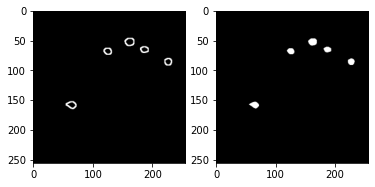

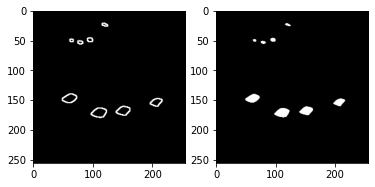

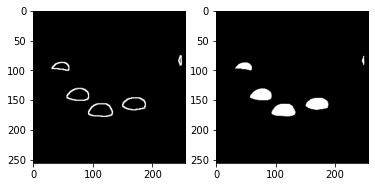

In [8]:
random.seed(777)

data_generator = create_data_generator(imgs_paths, 256, 1, border_size=3, aug_fn=augmentation_function)

for batch_inputs, batch_labels in islice(data_generator, 5):
    
    plt.subplot(1, 2, 1)
    plt.imshow(batch_inputs[0, ..., 0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(batch_labels[0, ..., 0], cmap='gray')
    plt.show()

## Построение модели нейронной сети

In [9]:
# Определение функции, которая будет использоваться для построения схожих участков нейронной сети.

def conv2d_block(
    inputs,
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):
    # Создаём элементарный блок, состоящий из двух свёрточных слоёв.
    conv_layer_1 = K.layers.Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
    )

    conv_layer_2 = K.layers.Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
    )

    x = conv_layer_1(inputs)
    x = conv_layer_2(x)
    return x

### Модель U-Net

In [10]:
def create_unet_model(
    input_shape,
    num_classes=1,
    dropout=0.5, 
    filters=64,
    num_layers=4,
    output_activation='sigmoid',
):
    # Строи модель U-Net
    inputs = K.Input(input_shape)
    x = inputs   

    # Создаём энкодер (Encoder)
    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters)
        down_layers.append(x)
        x = K.layers.MaxPooling2D((2, 2), strides=2) (x)
        filters = filters * 2  # Увеличиваем количество каналов на каждой стадии вдвое.

    x = K.layers.Dropout(dropout)(x)
    x = conv2d_block(inputs=x, filters=filters)

    # Создаём декодер
    for conv in reversed(down_layers):
        # conv - данные для skip-connection с соответствующей стадии энкодера.
        filters //= 2  # Уемньшаем количество каналов на каждой стадии декодера вдвое.
        x = K.layers.UpSampling2D(size=(2,2))(x)
        x = K.layers.Conv2D(filters, 2, activation='relu', padding='same', kernel_initializer='he_normal')(x)
        x = K.layers.concatenate([x, conv])
        x = conv2d_block(inputs=x, filters=filters)

    outputs = K.layers.Conv2D(num_classes, (1, 1), activation=output_activation)(x)    

    model = K.Model(inputs=[inputs], outputs=[outputs])
    return model

In [11]:
# Очищаем текущую сессию от возможно присутствующих предыдущих построенных моделей (при повторных вызовах).
K.backend.clear_session()

# Создаём модель (размер входа соответствует размеру данных, которые мы готовим в нашем генераторе данных)
IMG_SIZE = 256
model = create_unet_model([IMG_SIZE, IMG_SIZE, 1])

In [12]:
# Для контроля правильности объявления модели можно произвести вывод "краткой" сводки
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [17]:
# Можно также произвести отрисовку структуры модели (которая чаще бывает более информативной)
K.utils.plot_model(model, show_layer_names=False, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Обучение модели U-Net

#### Получаем список изображений и перемешиваем его

In [18]:
imgs_paths = get_masks_path('/content/drive/MyDrive/Datasets/nails/labels')

random.seed(123)
random.shuffle(imgs_paths)

# Разбиваем данные на тренировочные и валидационные
VAL_IMGS_NUM = 8
TRAIN_IMNGS_NUM = len(imgs_paths) - VAL_IMGS_NUM

train_imgs_path = imgs_paths[:-VAL_IMGS_NUM]
val_imgs_paths = imgs_paths[-VAL_IMGS_NUM:]

print('Train images number:', TRAIN_IMNGS_NUM)
print('Validation images number:', VAL_IMGS_NUM)

Train images number: -8
Validation images number: 8


In [19]:
def validate(val_mode, val_data, img_size, border_size=3):
    random.seed(5)
    validation_data_generator = create_data_generator(val_data, img_size, 1, border_size=border_size)

    for batch_inputs, batch_labels in validation_data_generator:

        model_output = val_mode.predict_on_batch(batch_inputs)

        plt.figure(figsize=(10, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(batch_inputs[0, ..., 0], cmap='gray')
        plt.title('Input')
        plt.subplot(1, 3, 2)
        plt.imshow(batch_labels[0, ..., 0], cmap='gray')
        plt.title('Label (Ground truth)')
        plt.subplot(1, 3, 3)
        plt.imshow(model_output[0, ..., 0], cmap='gray')
        plt.title('Prediction')
        plt.show()

#### Строим модель

In [20]:
# Очищаем текущую сессию от возможно присутствующих предыдущих построенных моделей (при повторных вызовах).
K.backend.clear_session()

random.seed(777)
np.random.seed(777)
# tf.set_random_seed(777)

# Создаём модель (размер входа соответствует размеру данных, которые мы готовим в нашем генераторе данных)
IMG_SIZE = 256
model = create_unet_model([IMG_SIZE, IMG_SIZE, 1])

# Привязываем к модели оптимизатор, функцию потерь и метрику, при помощи которой будем оценивать качество работы сети
model.compile(optimizer = K.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=[K.metrics.MeanIoU(num_classes=2)])

C:\Users\gnome\mambaforge\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Предварительно проверяем качество модели

In [21]:
validate(model, val_imgs_paths[4:], IMG_SIZE)

#### Производим обучение на трёх эпохах

In [22]:
BATCH_SIZE = 4
EPOCHS_NUMBER = 3

# Создаём тренировочный генератор, расчитанный на несколько эпох
train_data_generator = train_generator(train_imgs_path, IMG_SIZE, BATCH_SIZE, EPOCHS_NUMBER, border_size=3, aug_fn=augmentation_function)

history = model.fit(train_data_generator, epochs=EPOCHS_NUMBER, steps_per_epoch=TRAIN_IMNGS_NUM // BATCH_SIZE)

StopIteration: 

#### Снова проверяем качество модели

In [ ]:
validate(model, val_imgs_paths[4:], IMG_SIZE)

> Модель явно начинает выполнять поставленную задачу, но стоит доучить

#### Производим дообучение ещё на 12 эпохах

In [ ]:
BATCH_SIZE = 2
EPOCHS_NUMBER = 17

# Создаём тренировочный генератор, расчитанный на несколько эпох
train_data_generator = train_generator(train_imgs_path, IMG_SIZE, BATCH_SIZE, EPOCHS_NUMBER, border_size=3, aug_fn=augmentation_function)

# Стартуем с предыдущей эпохи (особенно важно, если у вас как то зависят параметры оптимизатора от номера эпохи)
# Также должна правильно обновляться история и производиться логнирование в TensorBoard
prev_epoch = history.epoch[-1] + 1
history = model.fit(
    train_data_generator,
    epochs=EPOCHS_NUMBER + prev_epoch,  # prev_epoch уже пройдено, и ещё новых EPOCHS_NUMBER
    steps_per_epoch=TRAIN_IMNGS_NUM // BATCH_SIZE,
    initial_epoch=prev_epoch,  # непосредственно указание, что prev_epoch пройдено
)

#### И ещё раз проверяем качество модели

In [ ]:
validate(model, val_imgs_paths[:], IMG_SIZE)

#### История на обучении

In [ ]:
plt.plot(history.epoch, history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot()

# Домашнее задание.

1. Произвести обучение модели для сегментации ногтей на фотографии. За основу модели взять архитектуру U-Net из урока.
2. Информацию об обучении необходимо вывести в Tensorboard.
3. Подобрать параметры оптимизатора (learning rate), а также количество эпох для достижения наилучшего соотношения "качество предсказания / время обучения"

